In [ ]:
!pip install jax jaxlib

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [ ]:

jax.config.update("jax_enable_x64", True)

In [ ]:
# Constants
k = 167  # W/m/K
density = 2770  # kg/m**3
Cp = 896  # J/kg/K
alpha = k / (density * Cp)
diameter = 0.025  # m
height = 0.075  # m
radius = diameter / 2
A_s = 2 * jnp.pi * radius * height  # m**2 #Area of Hollow Cylinder Formula
volume = jnp.pi * radius**2 * height  # m**3
mass = density * volume  # kg

In [ ]:
@jit
def linear_interpolation(x, x_p, y_p):
    slopes = (y_p[1:] - y_p[:-1]) / (x_p[1:] - x_p[:-1])
    indices = jnp.searchsorted(x_p, x) - 1
    indices = jnp.clip(indices, 0, len(slopes) - 1)
    return y_p[indices] + slopes[indices] * (x - x_p[indices])

@jit
def find_RMSE(exp_time, t_steps, cylinder_T, T_c):
    sim_temp = linear_interpolation(exp_time, t_steps, T_c)
    residual = (cylinder_T - sim_temp) ** 2
    RMSE = jnp.sqrt(jnp.mean(residual))
    return RMSE

@jit
def compute_temperature(h, dr, dt, x_steps, t_steps, ic, T_ambient):
    n_x = len(x_steps)
    n_t = len(t_steps)
    s = alpha * dt / dr**2

    T = jnp.zeros((n_t, n_x))
    T = T.at[0].set(ic)

    def update_step(m, T):
        def update_inner(i, T_prev):
            a_i = s - s / (2 * i)
            b_i = 1 - 2 * s
            c_i = s + s / (2 * i)
            return T_prev.at[i].set(a_i * T[m-1, i-1] + b_i * T[m-1, i] + c_i * T[m-1, i+1])

        T_inner = jax.lax.fori_loop(1, n_x-1, update_inner, T[m])
        T_inner = T_inner.at[0].set(T_inner[1])  # symmetry boundary condition

        H = - h * A_s * dt / (mass * Cp)
        T_inner = T_inner.at[-1].set(H * (T[m-1, -1] - T_ambient) + T[m-1, -1])

        return T.at[m].set(T_inner)

    T = jax.lax.fori_loop(1, n_t, update_step, T)

    return T

@jit
def objective(h, dr, dt, x_steps, t_steps, exp_time, cylinder_T, ic, T_ambient):
    T = compute_temperature(h, dr, dt, x_steps, t_steps, ic, T_ambient)
    return find_RMSE(exp_time, t_steps, cylinder_T, T[:, 0])




def plot_results(exp_time, cylinder_T, t_steps, T, title):
    plt.figure(figsize=(10, 6))
    plt.plot(t_steps, T[:, 0], label='Simulated')
    plt.plot(exp_time, cylinder_T, 'ro', markersize=2, label='Experimental')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (°C)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_rmse_vs_h(h_range, rmse_values, title):
    plt.figure(figsize=(10, 6))
    plt.plot(h_range, rmse_values, 'b-')
    plt.xlabel('Heat Transfer Coefficient h (W/m²K)')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True)
    plt.show()



In [ ]:
def optimize_h_with_plots(exp_time, cylinder_T, T_ambient, dr, dt, h_range_general, h_range_specific):
    x_steps = jnp.arange(0, radius + dr, step=dr)
    t_steps = jnp.arange(0, exp_time[-1] + dt, step=dt)
    ic = cylinder_T[0]

    objective_partial = jax.jit(lambda h: objective(h, dr, dt, x_steps, t_steps, exp_time, cylinder_T, ic, T_ambient))

    # General range optimization
    rmse_values_general = [objective_partial(h) for h in h_range_general]
    best_h_general = h_range_general[np.argmin(rmse_values_general)]
    plot_rmse_vs_h(h_range_general, rmse_values_general, "Figure A-11: Basic Optimization of h for Forced Convection Trial 1")

    # Specific range optimization
    rmse_values_specific = [objective_partial(h) for h in h_range_specific]
    best_h_specific = h_range_specific[np.argmin(rmse_values_specific)]
    plot_rmse_vs_h(h_range_specific, rmse_values_specific, "Figure A-12: Increased Optimization of h for Forced Convection Trial 1")

    # Optimized h value plot
    h_optimized = 17.6  # W/m²K
    h_range_optimized = jnp.linspace(h_optimized - 1, h_optimized + 1, 100)
    rmse_values_optimized = [objective_partial(h) for h in h_range_optimized]
    plot_rmse_vs_h(h_range_optimized, rmse_values_optimized,
                   "Figure A-10: Optimized h value for Forced Convection Trial 1")

    return best_h_specific, min(rmse_values_specific)

In [ ]:
# Load and process data
def load_data(filename):
    data = pd.read_csv(filename)
    exp_time = jnp.array(data.iloc[:, 0].values)
    cylinder_T = jnp.array(data.iloc[:, 1].values)
    ambient_T = jnp.array(data.iloc[:, 2].values)
    T_ambient = jnp.mean(ambient_T)
    return exp_time, cylinder_T, T_ambient


Processing Forced Convection Trial 1


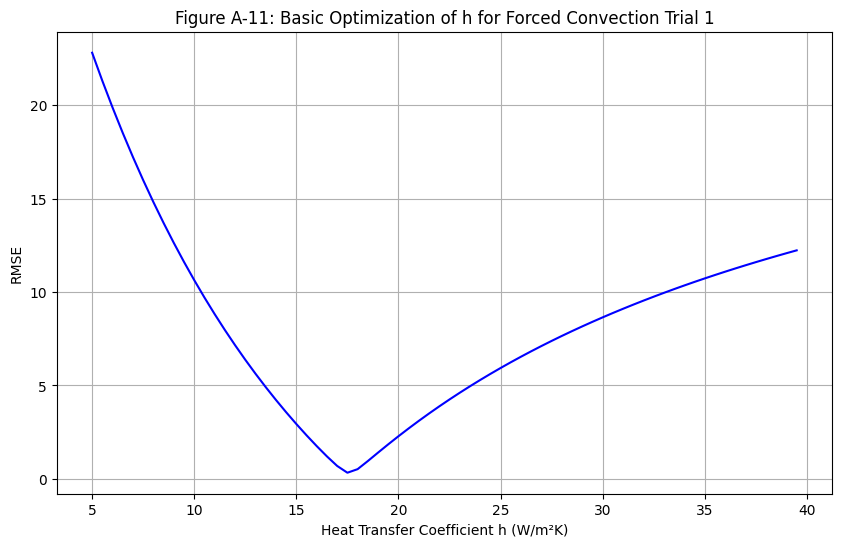

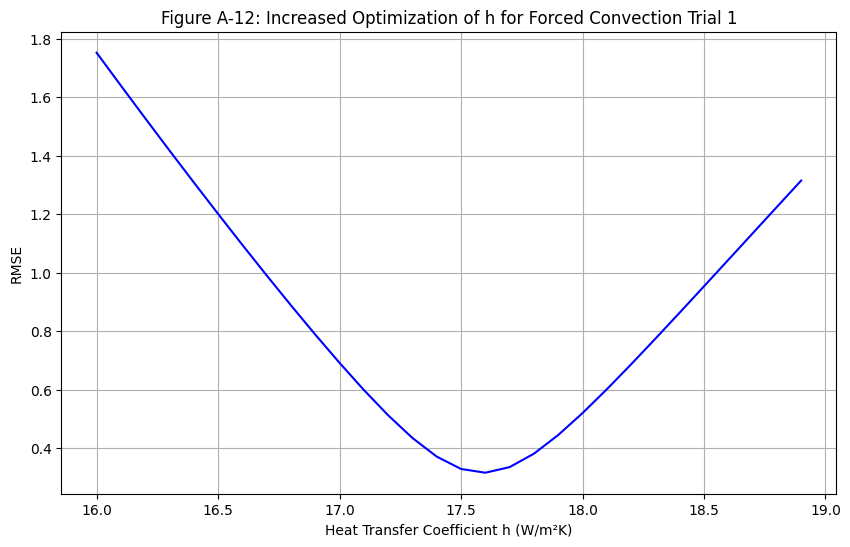

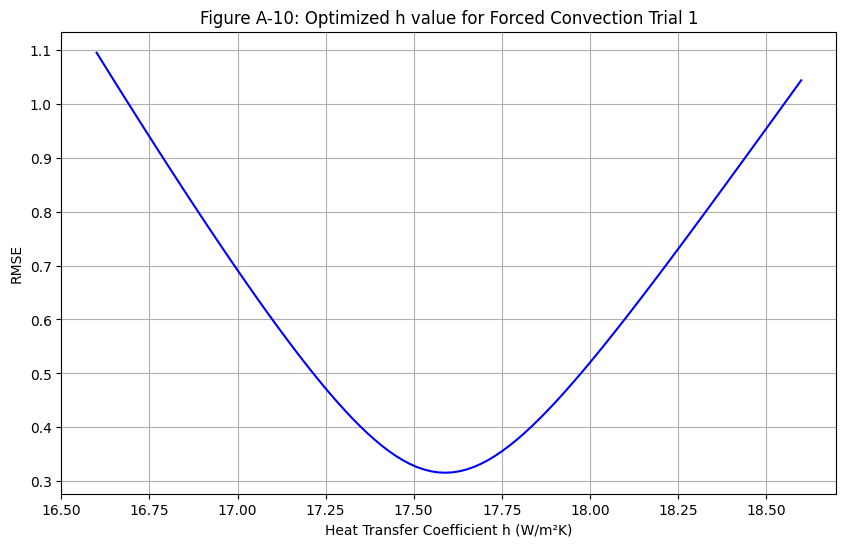

Optimized h: 17.60 W/m²K, RMSE: 0.3160


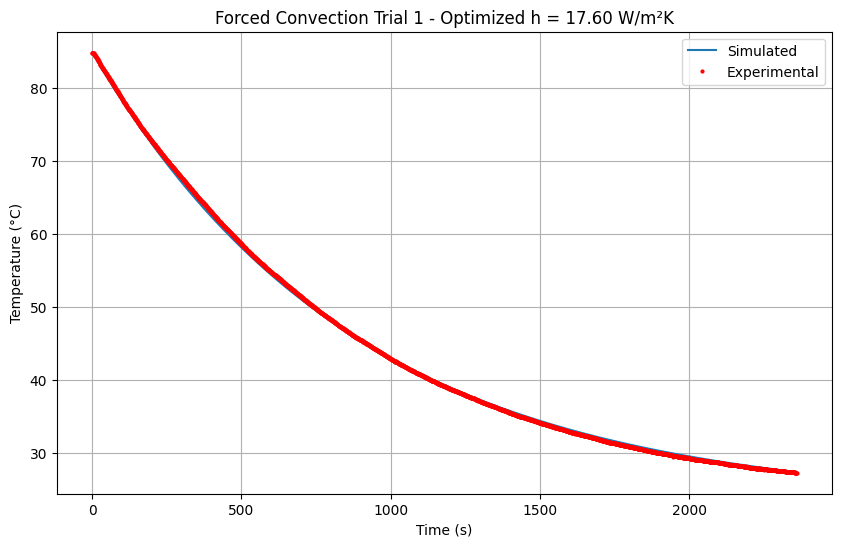

Simulation completed.


In [ ]:
# Main execution
if __name__ == "__main__":
    # Process Forced Convection Trial 1
    name, filename = "Forced Convection Trial 1", "/content/Forced Convection Trial 1-1.csv"
    print(f"Processing {name}")
    exp_time, cylinder_T, T_ambient = load_data(filename)

    dr = 0.00125
    dt = 0.01
    h_range_general = jnp.arange(5, 40, 0.5)
    h_range_specific = jnp.arange(16, 19, 0.1)

    best_h, best_rmse = optimize_h_with_plots(exp_time, cylinder_T, T_ambient, dr, dt, h_range_general, h_range_specific)
    print(f"Optimized h: {best_h:.2f} W/m²K, RMSE: {best_rmse:.4f}")

    x_steps = jnp.arange(0, radius + dr, step=dr)
    t_steps = jnp.arange(0, exp_time[-1] + dt, step=dt)
    T = compute_temperature(best_h, dr, dt, x_steps, t_steps, cylinder_T[0], T_ambient)

    plot_results(exp_time, cylinder_T, t_steps, T, f"{name} - Optimized h = {best_h:.2f} W/m²K")

    print("Simulation completed.")
